# 라이브러리 임포트

In [21]:
import os
import cv2
import easyocr
import itertools
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [22]:
# EasyOCR 초기화 (한글 + 영어)
reader = easyocr.Reader(['ko', 'en'], gpu=False)

# 프레임 이미지 폴더 경로
frame_folder = '/Users/chami/Desktop/monu/data/frames/20250321_1.0'  # 너가 저장한 경로로 바꿔줘

# 결과 저장할 리스트
ocr_results = []

# 이미지 순회
for filename in sorted(os.listdir(frame_folder)):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(frame_folder, filename)
        image = cv2.imread(img_path)

        # 이미지에서 자막 부분만 crop (하단 30%)
        h, w, _ = image.shape
        cropped = image[int(h*0):, :]

        # OCR 수행
        result = reader.readtext(cropped, detail=0)  # detail=0이면 텍스트만 리스트로 반환
        text = ' '.join(result).strip()
        print(f"{filename}: {text}")
        ocr_results.append((filename, text))

Using CPU. Note: This module is much faster with a GPU.


frame_00001.jpg: TARA 모즘 느낌놓다는 자라  확민하러 갚다가. .
frame_00002.jpg: ZARA 모즘 느낌종다는 자라 확민하러 갚다가. S/SNew
frame_00003.jpg: TARA 코즘 느낌종다는 자라 확민하러 갚다가. SIS New! 푹


KeyboardInterrupt: 

## 전처리 함수

In [14]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def blur(img):
    return cv2.GaussianBlur(img, (5, 5), 0)

def otsu(img):
    if len(img.shape) == 3:
        img = grayscale(img)
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

def adaptive(img):
    if len(img.shape) == 3:
        img = grayscale(img)
    blur_img = cv2.GaussianBlur(img, (5, 5), 0)
    return cv2.adaptiveThreshold(blur_img, 255,
                                 cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 11, 2)

def contrast(img):
    img = grayscale(img) if len(img.shape) == 3 else img
    return cv2.convertScaleAbs(img, alpha=1.5, beta=20)

def invert(img):
    img = grayscale(img) if len(img.shape) == 3 else img
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return cv2.bitwise_not(thresh)

## 전처리 조합 테스트

In [ ]:
# 조합할 전처리 함수 목록
preprocess_funcs = {
    'grayscale': grayscale,
    'blur': blur,
    'otsu': otsu,
    'adaptive': adaptive,
    'contrast': contrast,
    'invert': invert
}

# 테스트 대상 이미지 (자막 하단 crop 적용)
img = cv2.imread("/Users/chami/Desktop/monu/data/frames/20250321_1.0/frame_00016.jpg")
h, w, _ = img.shape
img = img[int(h*0.7):, :]  # 자막 영역

# 결과 저장
results = {}

# 전처리 함수 조합: 1~3개짜리 조합
for r in range(1, 4):
    for combo in itertools.permutations(preprocess_funcs.keys(), r):
        processed = img.copy()
        try:
            for step in combo:
                processed = preprocess_funcs[step](processed)
            text = ' '.join(reader.readtext(processed, detail=0))
            results[" → ".join(combo)] = text

            # 시각화 예시
            plt.figure()
            plt.imshow(processed, cmap='gray')
            plt.title(f"{' → '.join(combo)}\n{text}")
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"❌ 조합 실패: {' → '.join(combo)} / {e}")

Using CPU. Note: This module is much faster with a GPU.
/Users/chami/anaconda3/envs/monu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chami/anaconda3/envs/monu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chami/anaconda3/envs/monu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46385 (\N{HANGUL SYLLABLE DDAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chami/anaconda3/envs/monu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46308 (\N{HANGUL SYLLABLE DEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chami/anaconda3/envs/monu/lib/python3.10/site-package

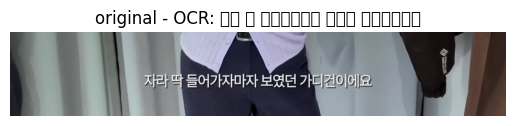

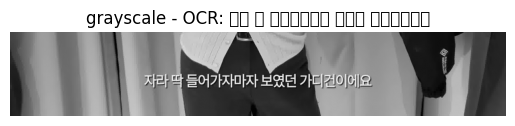

/Users/chami/anaconda3/envs/monu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


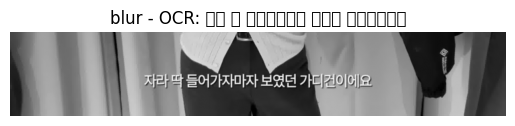

/Users/chami/anaconda3/envs/monu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chami/anaconda3/envs/monu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45912 (\N{HANGUL SYLLABLE DEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chami/anaconda3/envs/monu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44428 (\N{HANGUL SYLLABLE GWEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chami/anaconda3/envs/monu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


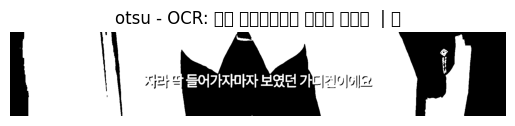

/Users/chami/anaconda3/envs/monu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chami/anaconda3/envs/monu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46989 (\N{HANGUL SYLLABLE RAB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chami/anaconda3/envs/monu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47932 (\N{HANGUL SYLLABLE MUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chami/anaconda3/envs/monu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chami/anaconda3/envs/monu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47549

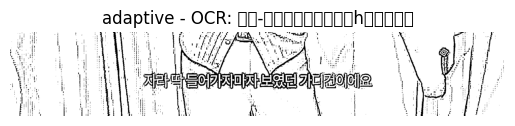

/Users/chami/anaconda3/envs/monu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chami/anaconda3/envs/monu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47700 (\N{HANGUL SYLLABLE ME}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chami/anaconda3/envs/monu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


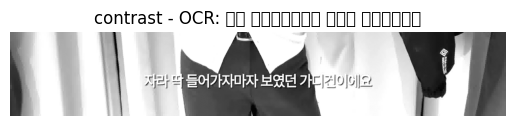

/Users/chami/anaconda3/envs/monu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46609 (\N{HANGUL SYLLABLE DDOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chami/anaconda3/envs/monu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50687 (\N{HANGUL SYLLABLE YEOS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chami/anaconda3/envs/monu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chami/anaconda3/envs/monu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chami/anaconda3/envs/monu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 457

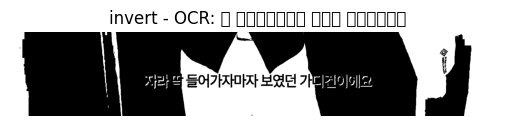


🔍 OCR 결과 비교
[original] 자라 딱 들어가자마자 보현단 가디건이에요
[grayscale] 자라 딱 들어가자마자 보현단 가디건이에요
[blur] 자라 딱 들어가자마자 보현년 가디건이에요
[otsu] 마라 들어가지마자 보현던 가디권  | 고
[adaptive] 차랍-물어리차마자보현립h리렌이에요
[contrast] 차라 딱들어가자마자 보현당 가디건이메도
[invert] 라 똑들어가자마자 보엿단 가디건미데다


In [ ]:
reader = easyocr.Reader(['ko', 'en'], gpu=False)

def apply_preprocessing(image, method):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if method == "grayscale":
        return gray
    elif method == "blur":
        return cv2.GaussianBlur(gray, (5, 5), 0)
    elif method == "otsu":
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return thresh
    elif method == "adaptive":
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        return cv2.adaptiveThreshold(blur, 255,
                                     cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY, 11, 2)
    elif method == "contrast":
        return cv2.convertScaleAbs(gray, alpha=1.5, beta=20)
    elif method == "invert":
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return cv2.bitwise_not(thresh)
    else:
        return image  # original

# 프레임 이미지 경로
img_path = "/Users/chami/Desktop/monu/data/frames/20250321_1.0/frame_00014.jpg"
image = cv2.imread(img_path)
h, w, _ = image.shape
cropped = image[int(h*0.7):, :]  # 자막 영역만

methods = ["original", "grayscale", "blur", "otsu", "adaptive", "contrast", "invert"]

# 실험 결과 저장
results = {}

for method in methods:
    processed = apply_preprocessing(cropped, method)
    result_texts = reader.readtext(processed, detail=0)
    results[method] = ' '.join(result_texts)

    # 시각화도 함께 보고 싶다면
    plt.figure()
    plt.imshow(processed, cmap='gray')
    plt.title(f"{method} - OCR: {results[method]}")
    plt.axis('off')
    plt.show()

# 결과 출력
print("\n🔍 OCR 결과 비교")
for method, text in results.items():
    print(f"[{method}] {text}")